# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [2]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct-gamma-limit"

nb_devices_for_the_run = 20

In [3]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [4]:
print(data.columns.values)

['number_of_elements' 'mean_atomic_mass' 'wtd_mean_atomic_mass'
 'gmean_atomic_mass' 'wtd_gmean_atomic_mass' 'entropy_atomic_mass'
 'wtd_entropy_atomic_mass' 'range_atomic_mass' 'wtd_range_atomic_mass'
 'std_atomic_mass' 'wtd_std_atomic_mass' 'mean_fie' 'wtd_mean_fie'
 'gmean_fie' 'wtd_gmean_fie' 'entropy_fie' 'wtd_entropy_fie' 'range_fie'
 'wtd_range_fie' 'std_fie' 'wtd_std_fie' 'mean_atomic_radius'
 'wtd_mean_atomic_radius' 'gmean_atomic_radius' 'wtd_gmean_atomic_radius'
 'entropy_atomic_radius' 'wtd_entropy_atomic_radius' 'range_atomic_radius'
 'wtd_range_atomic_radius' 'std_atomic_radius' 'wtd_std_atomic_radius'
 'mean_Density' 'wtd_mean_Density' 'gmean_Density' 'wtd_gmean_Density'
 'entropy_Density' 'wtd_entropy_Density' 'range_Density'
 'wtd_range_Density' 'std_Density' 'wtd_std_Density'
 'mean_ElectronAffinity' 'wtd_mean_ElectronAffinity'
 'gmean_ElectronAffinity' 'wtd_gmean_ElectronAffinity'
 'entropy_ElectronAffinity' 'wtd_entropy_ElectronAffinity'
 'range_ElectronAffinity' 'w

In [5]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [6]:
dim_notebook = len(data.columns) - 1
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [7]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [8]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [9]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [10]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")


# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  1063
There is 20 devices.
torch.Size([1063, 82])


# Handling non-iid data

superconduct-gamma-limit-tsne
There is 20 devices.
Number of points on device 0 : 448
Number of points on device 1 : 1321
Number of points on device 2 : 175
Number of points on device 3 : 689
Number of points on device 4 : 771
Number of points on device 5 : 3424
Number of points on device 6 : 677
Number of points on device 7 : 239
Number of points on device 8 : 1635
Number of points on device 9 : 664
Number of points on device 10 : 274
Number of points on device 11 : 1970
Number of points on device 12 : 2001
Number of points on device 13 : 775
Number of points on device 14 : 249
Number of points on device 15 : 1934
Number of points on device 16 : 360
Number of points on device 17 : 1634
Number of points on device 18 : 1766
Number of points on device 19 : 257
CPU times: user 39min 46s, sys: 6min 28s, total: 46min 15s
Wall time: 16min 22s


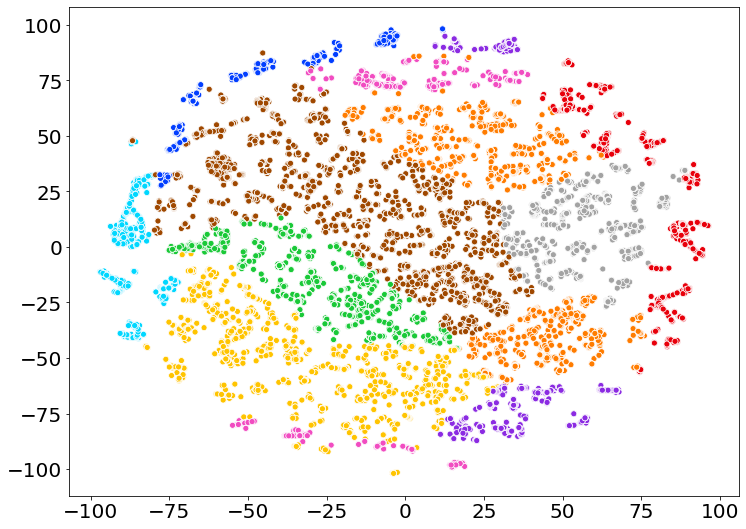

In [10]:
%%time
nb_cluster = nb_devices_for_the_run
print("{0}-tsne".format(filename))
embedded_data = pickle_loader("superconduct-tsne")
# Finding clusters in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "critical_temp", nb_cluster, scale_Y=True)
dim_notebook = X[0].shape[1] - 1

In [11]:
from src.utils.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Number of points on device 0 : 1063
Number of points on device 1 : 1063
Number of points on device 2 : 1063
Number of points on device 3 : 1063
Number of points on device 4 : 1063
Number of points on device 5 : 1063
Number of points on device 6 : 1063
Number of points on device 7 : 1063
Number of points on device 8 : 1063
Number of points on device 9 : 1063
Number of points on device 10 : 1063
Number of points on device 11 : 1063
Number of points on device 12 : 1063
Number of points on device 13 : 1063
Number of points on device 14 : 1063
Number of points on device 15 : 1063
Number of points on device 16 : 1063
Number of points on device 17 : 1063
Number of points on device 18 : 1063
Number of points on device 19 : 1063


In [12]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X_r, Y_r, nb_devices_for_the_run)

In [22]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
     200 | 3.1694e-01
     400 | 3.0294e-01
     600 | 2.9766e-01
     800 | 2.9443e-01
Gradient Descent: execution time=9.046 seconds
Final loss : 0.29203

CPU times: user 35.9 s, sys: 252 ms, total: 36.1 s
Wall time: 9.05 s


In [16]:
step_formula = [(lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L)),
                (lambda it, L, omega, N: 1 / (64*L)),
                ]

label_step_formula = ["N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$",
                "$64L^{-1}$",
                ]

## Batch size $= 50$ (stochastic)

In [32]:
%%time
batch_size = 50

all_kind_of_compression_res = []
all_descent_various_gamma = {}
descent_by_algo_and_step_size = {}

#Corresponds to descent with optimal gamma for each algorithm
optimal_descents = {}

for type_params in tqdm(KIND_COMPRESSION):
    losses_by_comp = []
    losses_avg_by_comp = []
    descent_by_step_size = {}
    for (formula, label) in zip(step_formula, label_step_formula):
        multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                                   use_averaging=True, stochastic=True, batch_size=batch_size, 
                                                   step_formula=formula,
                                                   nb_epoch=250, logs_file="{0}.txt".format(filename))
        
        descent_by_step_size[label] = multiple_sg_descent
        losses_by_formula, losses_avg_by_formula = [], []
        
        # Picking the minimum values for each of the run.
        for sequence_of_losses, sequence_of_losses_avg in zip(multiple_sg_descent.losses, multiple_sg_descent.averaged_losses):
            losses_by_formula.append(min(sequence_of_losses))
            losses_avg_by_formula.append(min(sequence_of_losses_avg))
        losses_by_comp.append(losses_by_formula)
        losses_avg_by_comp.append(losses_avg_by_formula)
        
    descent_by_algo_and_step_size[type_params.name()] = ResultsOfSeveralDescents(descent_by_step_size, nb_devices_for_the_run)
    
    # Find optimal descent for the algo:
    min_loss_desc = 10e12
    opt_desc = None
    for desc in descent_by_step_size.values():
        if min_loss_desc > min([desc.losses[j][-1] for j in range(len(desc.losses))]):
            min_loss_desc = min([desc.losses[j][-1] for j in range(len(desc.losses))])
            opt_desc = desc
    # Adding the optimal descent to the dict of optimal descent
    optimal_descents[type_params.name()] = opt_desc
    
    artificial_multiple_descent = MultipleDescentRun()
    artificial_multiple_descent.append_list(losses_by_comp, losses_avg_by_comp)
    all_descent_various_gamma[type_params.name()] = artificial_multiple_descent
    all_kind_of_compression_res.append(all_descent_various_gamma)
    
res_various_gamma = ResultsOfSeveralDescents(all_descent_various_gamma, nb_devices_for_the_run)
pickle_saver(res_various_gamma, "{0}-alldescent".format(filename))

res_opt_gamma = ResultsOfSeveralDescents(optimal_descents, nb_devices_for_the_run)
pickle_saver(res_opt_gamma, "{0}-optimal_descents".format(filename))

pickle_saver(descent_by_algo_and_step_size, "{0}-descent_by_algo_and_step_size".format(filename))

100%|██████████| 5/5 [01:32<00:00, 18.54s/it]

CPU times: user 5min 15s, sys: 2.51 s, total: 5min 17s
Wall time: 1min 32s


## Without averaging

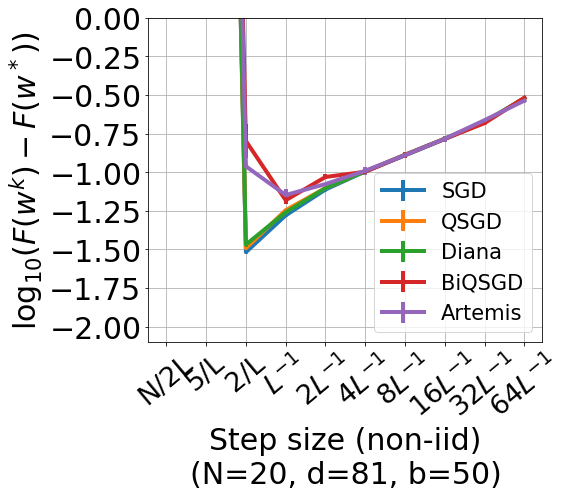

In [40]:
batch_size = 50
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Step size (non-iid)", one_on_two_points=False,
               xlabels=label_step_formula, ylim=True)

## With averaging

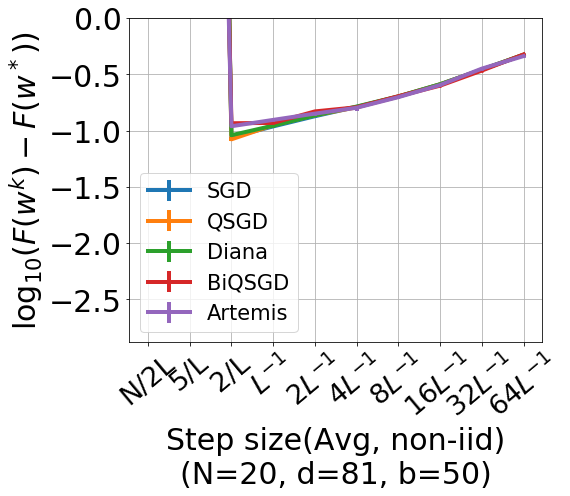

In [39]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size(Avg, non-iid)", one_on_two_points=False,
               xlabels=label_step_formula, ylim=True) 

### Display loss for each algorithm

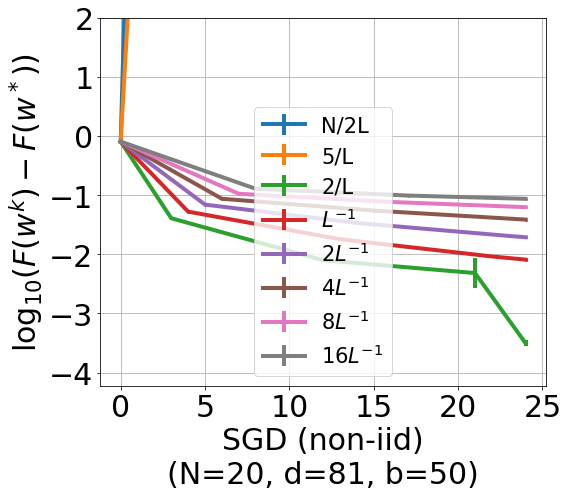

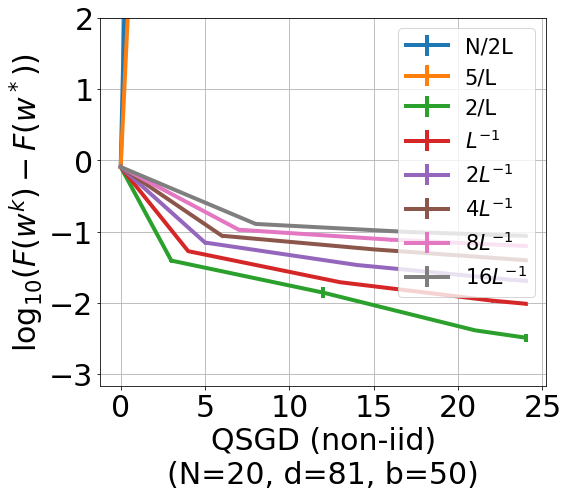

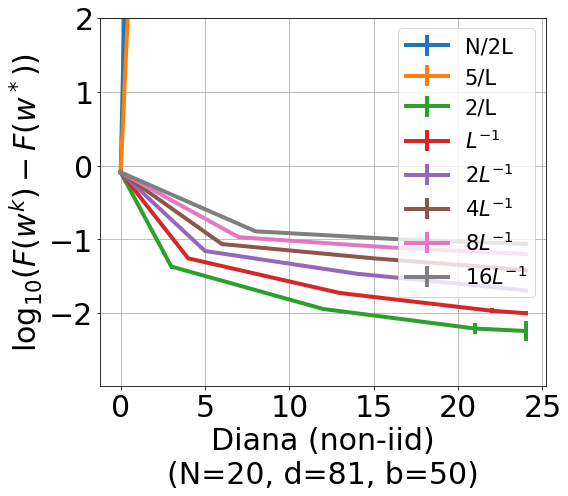

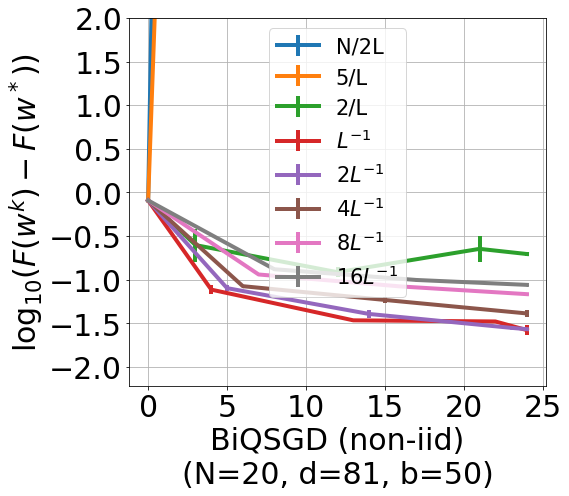

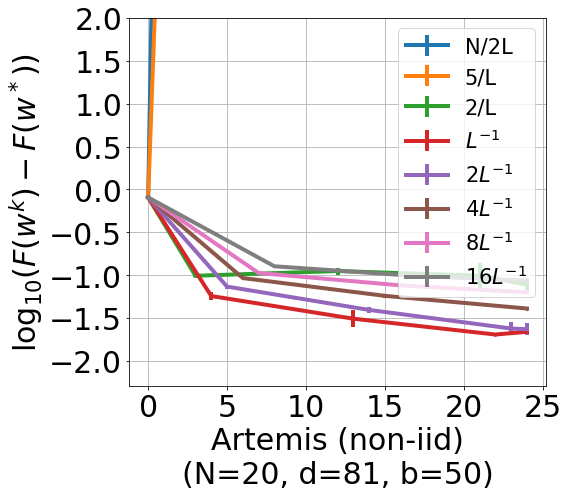

In [30]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-descent_by_algo_and_step_size".format(filename))
for algo_name, algo in res.items():
    plot_error_dist(algo.get_loss(obj), algo.names, algo.nb_devices_for_the_run, dim_notebook, 
                    batch_size=batch_size, all_error=algo.get_std(obj), x_legend="{0} (non-iid)".format(algo_name),
                   ylim=True) 


### Display algo with its optimal step size

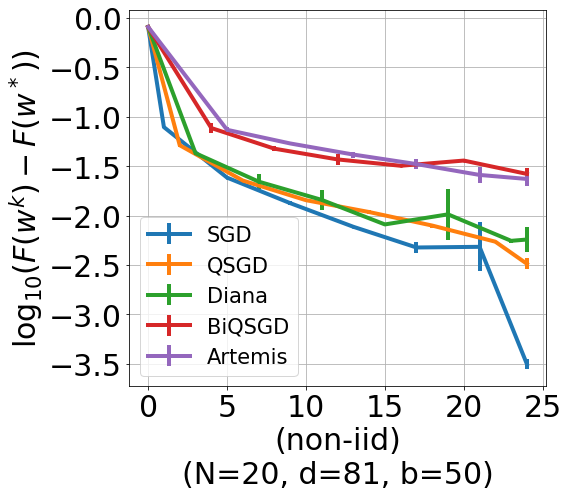

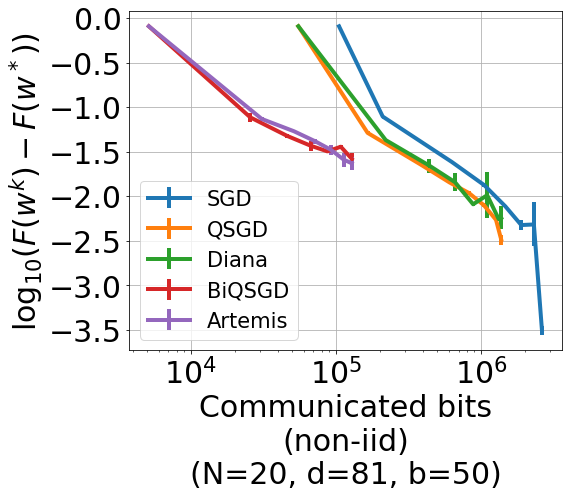

In [31]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-optimal_descents".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj), batch_size=batch_size,
                x_legend="(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 